In [27]:
%load_ext autoreload
%autoreload 2
import random
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from Openseas_Methods import *
from pycoingecko import CoinGeckoAPI
from datetime import datetime,timedelta
import numpy as np
from scipy.stats import pearsonr,spearmanr
import pickle
import decision_tree as tree
from itertools import islice
from decision_tree import get_eth_price
from pymongo import MongoClient

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
client = MongoClient()
db = client.NFTDB
collection_data = db.salesCollection
stats_collection = db.NFTStats
slug_collection = db.completedSlugs
combos = db.NFT
skip_list=['ens','base-introduced','fundrop-pass','gemesis','apecoin','dai-stablecoin','uniswap','1inch-token']
address_type = 'seller_address'

In [29]:
records = collection_data.find({})

In [30]:
df = pd.DataFrame.from_records(records)

In [31]:
df

,_id,auction_type,buyer_address,buyer_username,event_type,is_bundle,payment_token,seller_address,seller_username,slug,timestamp,token_id,total_price,usd_price
0,0x53194272a87154c17130d2b466b3c7ce432051388d00...,None,0xd3f5ee617d302fb17a5cf7fdb749fa638bc9ddcc,None,successful,False,ETH,0x4fb1136a1122b2312089b0a7ba2111866a6f7b59,BadgerBot,atsnft,2023-09-02T22:02:23,129,0.7247,1636.34
1,0x4443b2d20a72e6d1cf6a3127f4efbffb2c0d51db3503...,None,0xcf86b3a45654fd54810ea19ea31b9cf104da349e,None,successful,False,WETH,0xf19869a67f8c741e117b600d57fce2e3e82934a2,Thumpie808,atsnft,2023-09-02T10:34:59,2103,0.5920,1635.75
2,0x3cf40d4dcbe9a779df1d4305161970f618223b5491ae...,None,0x4fb1136a1122b2312089b0a7ba2111866a6f7b59,BadgerBot,successful,False,WETH,0x26e19f531a537a9420c78a80602b3fa79181a714,NFT_Playground,atsnft,2023-09-02T03:04:47,129,0.6336,1635.75
3,0xb373af8a67cf256630642e7e092c1ec04eabe5c2daec...,None,0xc0c27d29ac68df3675ed3e5e24acc571e0dcc710,bellyhungrybebe,successful,False,WETH,0x1d53c9c777ec29340caabf2111390999ca466729,pelon_santacruz,atsnft,2023-09-02T02:10:47,2551,0.6332,1635.75
4,0xba2120f31e390aec3d4bbc22cc8deb8e807035dfc199...,None,0x7f2bfa8482be65c5fb2c42c21b4e382244eb0e87,MoonAlpha,successful,False,WETH,0x2099525d87931c9cac440e656ff5ce73e6a7b365,Fung_vault,atsnft,2023-09-01T21:23:47,2251,0.6700,1635.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121362,0x0f6b8d8c378d4a15fee4626e41df31c45ac9c67e4ef3...,None,0x582bf12932381d7bf50a763ffd2acc9b4b2a3d53,OGG_MIGS_VAULT,successful,False,ETH,0xf31a1b599694e16fcafd1352be648cb35c9958d0,None,shylock,2023-02-26T04:05:35,4677,0.0095,1560.89
3121363,0x25c85e741fecd391dffb7e4af0242dcfbe9cdb060f25...,None,0x9ab17bdaa2ab4a70aedd11a2a2641a14d5b23ddb,MitchNZ,successful,False,ETH,0xd19de40105288012b1e0292da7067984998c381d,None,shylock,2023-02-26T04:05:35,355,0.0089,1560.89
3121364,0x6b1e44d9c99909a390dcb5d44e10e8fb8332daa84ea4...,None,0xf39138ba989edf3547ab77d09dc10a26f365fe83,lswfyre,successful,False,ETH,0x324019236c1c964bff5019e3be400abb4ccd6e15,None,shylock,2023-02-26T04:03:47,4875,0.0083,1560.89
3121365,0x456177f66c0d1bdeb5e51a94ea95f6600fa40dfb16e5...,None,0x4326275317acc0fae4aa5c68fce4c54c74dc08d3,None,successful,False,ETH,0x4160f55dd11a0426a2b2212601f5a96d3c268007,None,shylock,2023-02-26T04:03:47,348,0.0089,1560.89


In [32]:

# Group by 'group_column' and extract 'total_price' and 'timestamp' columns as lists
grouped_data = df.groupby(address_type).agg({
    'total_price': list,
    'timestamp': list
}).reset_index()

# Print the grouped data (optional)
grouped_data

,seller_address,total_price,timestamp
0,0x000000000000fd461ca2d54e8f4b3e37749df921,[0.685],[2022-07-12T01:49:11]
1,0x0000000000015b23c7e20b0ea5ebd84c39dcbe60,"[5.5, 3.5000000000000004, 0.23, 0.23, 0.05, 0.2]","[2021-07-01T06:07:18, 2021-06-07T23:09:17, 202..."
2,0x000000000002e33d9a86567c6dfe6d92f6777d1e,"[9.5, 11.940000000000001, 11.13]","[2022-12-26T17:01:11, 2022-12-26T10:11:47, 202..."
3,0x000000000004d7463d0f9c77383600bc82d612f5,"[6.6000000000000005, 4.5, 2.6, 2.5]","[2021-12-29T07:06:49, 2021-11-24T07:32:01, 202..."
4,0x0000000000060c75d139d234616a4c14a594368f,[0.32],[2023-03-08T18:25:11]
...,...,...,...
432875,0xffffc729160fa4670907cbf9e14fa41a55e6100d,"[0.11800000000000001, 0.08800000000000001]","[2022-08-11T22:16:48, 2022-07-12T09:59:55]"
432876,0xffffc801a3e4ceddd58b6280006819e14129145b,"[0.3632, 0.27540000000000003, 0.15430000000000...","[2023-08-12T01:24:47, 2023-08-02T02:44:47, 202..."
432877,0xfffff449f1a35eb0facca8d4659d8e15cf2f77ba,[1.62],[2023-01-18T04:57:11]
432878,0xffffff55fc62fac0f1cdb23628cc9c367a7f1090,[1.4200000000000002],[2023-07-04T03:55:11]


In [72]:
filtered_result = grouped_data[grouped_data['total_price'].apply(lambda x: len(x) >= 40)]

In [73]:
filtered_result = filtered_result.reset_index()

In [74]:
filtered_result

,index,seller_address,total_price,timestamp
0,14,0x00000000009a41862f3b2b0c688b7c0d1940511e,"[87.60000000000001, 91.238, 95.0, 0.05, 0.0220...","[2022-01-14T21:32:06, 2022-01-14T20:15:39, 202..."
1,37,0x000000007d905ab8199381328c3fb0a75754b6af,"[0.43169, 0.32, 0.3196, 0.3196, 0.090000000000...","[2023-02-20T06:13:11, 2023-02-20T05:32:47, 202..."
2,48,0x00000005d8fe54bdf696d72db37c9bb09ac80088,"[0.5990000000000001, 7.7700000000000005, 4.5, ...","[2022-06-07T03:52:55, 2021-08-23T21:33:55, 202..."
3,78,0x0000006f43b26ba724ae3ddb0c55536d64e5f985,"[0.67, 0.6999000000000001, 0.7287, 0.740000000...","[2023-08-18T00:41:59, 2023-08-16T15:30:11, 202..."
4,98,0x000001f568875f378bf6d170b790967fe429c81a,"[4.773883966968923, 4.879477181689782, 3.26499...","[2022-06-07T18:11:52, 2021-09-05T22:20:59, 202..."
...,...,...,...,...
12859,432660,0xffdef5e9eeaceac0800a2f784105105dbaf1d884,"[0.25, 0.30000000000000004, 0.4700000000000000...","[2023-04-22T01:28:35, 2023-04-21T15:23:47, 202..."
12860,432709,0xffe6830ee2e4caf60911bcb623038c21b49aaab6,"[2.9800000000000004, 6.500000000000001, 1.239,...","[2023-07-09T12:25:35, 2023-07-08T00:40:47, 202..."
12861,432833,0xfffa6fc6acc3dbe04b175862376f1c5ff88cf9c1,"[0.4099999999, 0.325, 0.335, 0.3568, 0.525, 0....","[2023-03-29T23:16:23, 2023-03-26T17:51:11, 202..."
12862,432850,0xfffc9d8e1c9b4d8aceb50fcba4a701413bb20099,"[0.4, 0.46, 0.47000000000000003, 0.48000000000...","[2023-03-18T17:01:11, 2023-03-15T16:51:35, 202..."


In [75]:
from scipy.stats import pearsonr
# Calculate Pearson correlation coefficient and p-value for each group
x = []
y = []
z = []
wallets = []
wall_to_corr = {}
wall_to_avg = {}
wall_to_conf = {}
for index, row in tqdm(filtered_result.iterrows(), total=len(filtered_result)):
    data = list(zip(row['total_price'],row['timestamp']))
    # data = random.choices(data,k=20)
    sale_prices = [x[0]*get_eth_price(x[1],1) for x in data if  x[1]]
    eth_prices = [get_eth_price(x[1],1) for x in data if x[1]]
    # Extract correlation coefficients and p-values into separate lists
    p = eth_prices
    q = sale_prices     
    corr2 = pearsonr(p,q)
    corr = spearmanr(p,q)
    wallets.append(row[address_type])
    wall_to_corr[row[address_type]] = corr.statistic
    wall_to_avg[row[address_type]] = sum(sale_prices)/len(sale_prices)
    wall_to_conf[row[address_type]] = corr2.confidence_interval()
    if corr.pvalue<0.01:
        x.append(index)
        y.append(corr.statistic)

  6%|██▎                                   | 773/12864 [00:02<00:41, 294.40it/s]/home/taylor/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/taylor/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
100%|████████████████████████████████████| 12864/12864 [00:47<00:00, 271.23it/s]


In [76]:
# Create a boolean mask using isin() function
mask = df[address_type].isin(wallets)

# Filter the DataFrame based on the mask
test_df = df[mask]

# Print the filtered DataFrame
test_df['slug']

0           atsnft
5           atsnft
6           atsnft
7           atsnft
8           atsnft
            ...   
3121350    shylock
3121351    shylock
3121357    shylock
3121364    shylock
3121366    shylock
Name: slug, Length: 1302591, dtype: object

In [77]:
test_df

,_id,auction_type,buyer_address,buyer_username,event_type,is_bundle,payment_token,seller_address,seller_username,slug,timestamp,token_id,total_price,usd_price
0,0x53194272a87154c17130d2b466b3c7ce432051388d00...,None,0xd3f5ee617d302fb17a5cf7fdb749fa638bc9ddcc,None,successful,False,ETH,0x4fb1136a1122b2312089b0a7ba2111866a6f7b59,BadgerBot,atsnft,2023-09-02T22:02:23,129,0.7247,1636.34
5,0x7149eeef046dac0ab8b80bbb1e0a8378078986478fde...,None,0x7f2bfa8482be65c5fb2c42c21b4e382244eb0e87,MoonAlpha,successful,False,ETH,0x39781bc43c91fa5cda0ecc8558abdbbcf4a4bc20,mbryanta,atsnft,2023-09-01T21:21:11,3853,0.7000,1636.34
6,0x9b0863d621374f115be9446c630e2cf1fe2ec6e7e289...,None,0x7f2bfa8482be65c5fb2c42c21b4e382244eb0e87,MoonAlpha,successful,False,ETH,0x39781bc43c91fa5cda0ecc8558abdbbcf4a4bc20,mbryanta,atsnft,2023-09-01T21:20:59,3398,0.7000,1636.34
7,0x9e01cded2e349902f78b83ef353a18edb46202a90899...,None,0x7f2bfa8482be65c5fb2c42c21b4e382244eb0e87,MoonAlpha,successful,False,ETH,0x39781bc43c91fa5cda0ecc8558abdbbcf4a4bc20,mbryanta,atsnft,2023-09-01T21:20:47,3923,0.7000,1636.34
8,0x3b329d531cf945e456fa4d2e0ede3f6c925ca5b28653...,None,0x7f2bfa8482be65c5fb2c42c21b4e382244eb0e87,MoonAlpha,successful,False,ETH,0x39781bc43c91fa5cda0ecc8558abdbbcf4a4bc20,mbryanta,atsnft,2023-09-01T21:20:23,3280,0.7000,1636.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121350,0x60c209dd7baf0ffeb34800708870a7a6f1bf378615bc...,None,0x003579b42dd45e4384e116ea92edf6fe44b0344c,None,successful,False,ETH,0x2a0e4ef6c7693ad911ee2d3a289f2707296f633b,TheRealTomNook,shylock,2023-02-26T04:35:47,1892,0.0090,1560.89
3121351,0x8836e84d2c0f0c38c94cc0fb7c4822bdebd2a675eb96...,None,0xdeab937a0c829597df8444851193d63016f7224d,None,successful,False,ETH,0x1f14f9c2ffab9111cdfd84e4d6f67852a749de46,MONKEYCEMONKEYDO,shylock,2023-02-26T04:29:35,271,0.0090,1560.89
3121357,0x1f28af3a96cc66ccf7871f2a9bc9e79cb22519ea6f67...,None,0x6fd17ec3cf93bf49fe5c745d274ace9024a48cb2,None,successful,False,ETH,0x2a0e4ef6c7693ad911ee2d3a289f2707296f633b,TheRealTomNook,shylock,2023-02-26T04:12:23,1891,0.0090,1560.89
3121364,0x6b1e44d9c99909a390dcb5d44e10e8fb8332daa84ea4...,None,0xf39138ba989edf3547ab77d09dc10a26f365fe83,lswfyre,successful,False,ETH,0x324019236c1c964bff5019e3be400abb4ccd6e15,None,shylock,2023-02-26T04:03:47,4875,0.0083,1560.89


In [78]:
import networkx as nx

B = nx.Graph()

# Add nodes with the 'bipartite' attribute set according to their type
B.add_nodes_from(test_df[address_type], bipartite=0)
nx.set_node_attributes(B,wall_to_corr,'corr')
# 0 indicates addresses
B.add_nodes_from(test_df['slug'], bipartite=1)
edges = [(row[address_type], row['slug']) for idx, row in test_df.iterrows()]
B.add_edges_from(edges,weight=1)
nx.write_gexf(B, "bipartite_graph.gexf")

In [79]:
print(B)

Graph with 13475 nodes and 211635 edges


In [80]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
addresses = {node for node, data in B.nodes(data=True) if data['bipartite'] == 0}
slugs = {node for node, data in B.nodes(data=True) if data['bipartite'] == 1}
# Generate the layout for the bipartite graph
# pos = nx.bipartite_layout(B, nodes=addresses)
# slug_to_num_owners = {}
# for slug in slugs:
#     try:
#         slug_to_num_owners[slug] = stats_collection.find_one({'slug':slug})["num_owners"]
#     except:
#         print(slug)
#         slug_to_num_owners[slug] = 1e10
# # Calculate in-degree for all nodes in the bipartite graph
# in_degrees = B.degree(slugs)
# # Define a threshold for high in-degree (you can adjust this threshold based on your requirements)
# high_in_degree_threshold = 0.01
# correlation_values = {node: B.nodes[node]['corr'] for node in addresses}
# color_map = [correlation_values.get(node, 0) for node in addresses]
# # Get the slug nodes with high in-degree
# high_in_degree_slugs = {node for node, in_degree in in_degrees if in_degree/slug_to_num_owners[node] >= high_in_degree_threshold}
# # Draw nodes and edges with smaller size
# nx.draw_networkx_nodes(B, pos, node_color=color_map, nodelist=addresses, node_size=1,cmap=cm.RdYlGn)  # Addresses in blue, node_size adjusted
# nx.draw_networkx_nodes(B, pos, node_color='b', nodelist=slugs, node_size=1)      # Slugs in red, node_size adjusted
# nx.draw_networkx_edges(B, pos, edgelist=B.edges(), width=0.1) 

# # Draw labels
# node_labels = {node: node for node in high_in_degree_slugs}
# nx.draw_networkx_labels(B, pos, labels=node_labels,font_size=8)

# # Normalize the correlation values for the color map
# norm = Normalize(vmin=min(color_map), vmax=max(color_map))

# # Create a ScalarMappable object with the correct color map and normalization
# sm = plt.cm.ScalarMappable(cmap=cm.RdYlGn, norm=norm)
# sm.set_array([])  # You need to set a dummy array for the ScalarMappable object

# # Add a colorbar to the plot
# plt.colorbar(sm, label='Correlation') 
# plt.show()

In [81]:
degrees = B.degree(addresses)
counts = []
value_counts = df.groupby(address_type).size().reset_index(name='count')

counts_dict = value_counts.set_index(address_type)['count'].to_dict()

In [82]:
x = []
y = []
p = []
q = []
m = []
n = []
w = []
for wall,degree in degrees:
    conf = wall_to_conf[wall]
    if abs(wall_to_corr[wall])<1 and degree<300:
        w.append(abs(conf.high-conf.low))
        x.append(degree)
        y.append(abs(wall_to_corr[wall]))  
        # y.append(wall_to_corr[wall])    
        p.append(counts_dict[wall])
        q.append(abs(wall_to_corr[wall]))
        m.append(wall_to_avg[wall])
        n.append(abs(wall_to_corr[wall]))

In [59]:
def wmean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

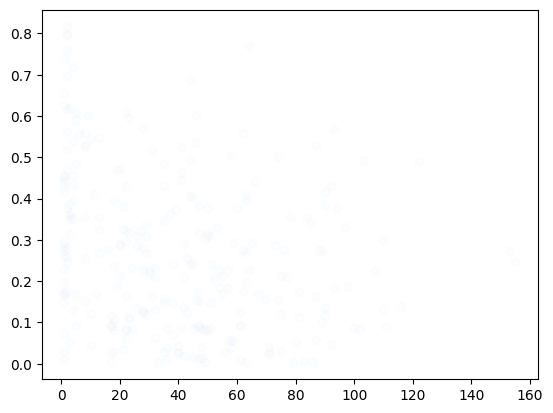

SignificanceResult(statistic=-0.26643434386289905, pvalue=1.0586779914220525e-05)


In [60]:
plt.scatter(x,y,alpha=0.01)
plt.show()
print(spearmanr(x,y))
# corr(np.array(x),np.array(y),np.array(w))

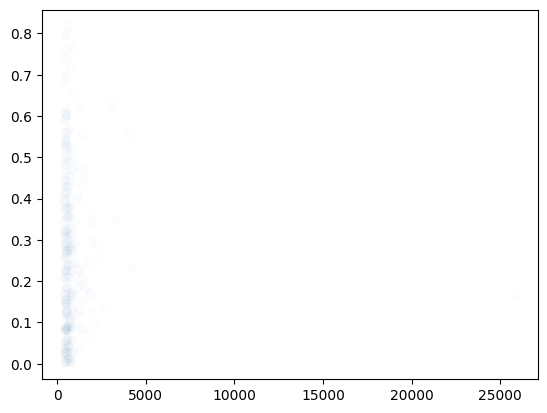

SignificanceResult(statistic=-0.05288590668955721, pvalue=0.3902951050536134)


In [61]:
plt.scatter(p,q,alpha=0.01)
plt.show()
print(spearmanr(p,q))
# corr(np.array(p),np.array(q),np.array(w))

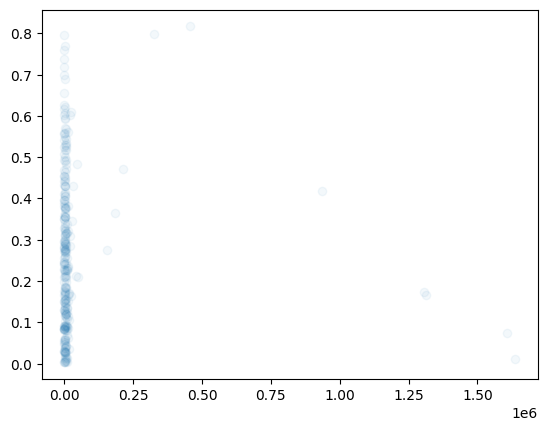

-0.06620104815534293

In [62]:
plt.scatter(m,n,alpha=0.05)
plt.show()
pearsonr(m,n)
corr(np.array(m),np.array(n),np.array(w))

In [ ]:
with open('combo_per.pkl','rb') as f:
    combo_perc = pickle.load(f)
features = tree.compute_graph_features(combo_perc,skip_list=skip_list,G=B)

In [ ]:
features

In [ ]:
with open('bipartite_features.pkl','wb') as f:
    pickle.dump(features)

In [94]:
labels = [0 if ele<0.3 else 1 for ele in y]
data = {
    'Num NFTS': x,
    'Num Trans': p,
    'Avg Vol':m,
    'labels':labels
}

# Create a pandas DataFrame
data = pd.DataFrame(data)
labels = data['labels']
features = data.drop(columns=['labels'])

'decision_tree_wallets.png'

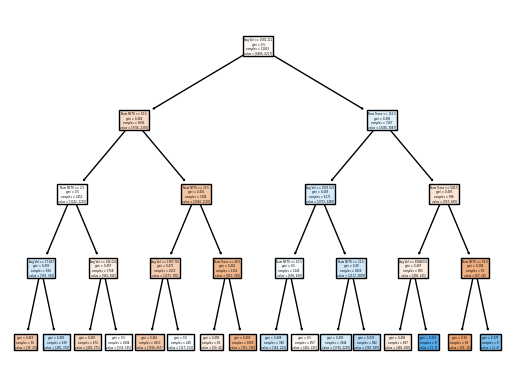

In [96]:
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz


clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(features, labels)
feature_names = features.columns
tree.plot_tree(clf,feature_names=feature_names,filled=True)
dot_data = tree.export_graphviz(clf, 
                      feature_names=feature_names,    
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png'  # You can change the format to 'pdf', 'png', 'jpg', etc.
graph.render("decision_tree_wallets")